In [1]:
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from torch.distributions.utils import logits_to_probs

from sklearn import linear_model
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam
from pyro.nn import PyroModule, PyroSample

from src.utils import load_data

### Load data

In [2]:
X, y, _ = load_data(impute=True)
X_train, X_test = X
y_train, y_test = y
print('Training:\nX-shape: {}, y-shape: {}'.format(X_train.shape, y_train.shape))
print('\nTesting:\nX-shape: {}, y-shape: {}'.format(X_test.shape, y_test.shape))

Training:
X-shape: (1676, 38), y-shape: (1676,)

Testing:
X-shape: (419, 38), y-shape: (419,)


##### Prepare data for model.

In [3]:
# standardize input features
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

##### Baseline linear regression

In [4]:
# create and fit regression model
lreg = linear_model.LinearRegression()
lreg.fit(X_train, y_train)

# make predictions for test set
y_hat_lreg = lreg.predict(X_test)
print("first 5 predictions:", y_hat_lreg[:5])
print("first 5 true values:", y_test[:5])

# evaluate prediction accuracy
print("MSE:", sum((y_hat_lreg - y_test)**2)/len(y_hat_lreg))

first 5 predictions: [ 3.30027249  7.4228757   4.50567392 14.34175354 15.8096688 ]
first 5 true values: [ 0  9  3 15 23]
MSE: 41.6031608924794


### Neural Network

Let $\textbf{X}_n$ denote the characteristics of the n'th area. We now instead assume that the relationship between $\textbf{X}_n$ and $y_n$ can be expressed through a non-linear mapping $f_{nnet}$, where for $m$ features we have the mapping
$$
f_{nnet}: \mathbb{R}^m \mapsto \mathbb{R},
$$

During the lectures, it was proposed to split the features up into two sets of features $\textbf{X}_n'$ and $\textbf{X}_n^*$ such that $\textbf{X}_n' \bigcup \textbf{X}_n^* = \textbf{X}_n$ and $\textbf{X}_n' \bigcap \textbf{X}_n^* = \emptyset$.
One set of features, $\textbf{X}_n'$, would then model a linear relationship between the variables, while the other, $\textbf{X}_n^*$, would undergo a non-linear transformation through a neural net, yielding

$$
\psi_n = \beta^T\textbf{X}_n' + f_{\text{nnet}}(\textbf{X}^*_n)+\phi_n.
$$

However, as a neural net is a universal function approximator (Bishop, p.230), it will discover and be able to model any linear dependecies, allowing us to simply apply the neural net to all of the features such that we may instead compute $\psi_n$ as

$$
\psi_n = f_{\text{nnet}}(\textbf{X}_n)+\phi_n.
$$

The following structure for the neural network was found to be the best through a series of tests on the training data:

| Layer | Number of neurons | Activation function |
|:-----:|:-----------------:|:-------------------:|
| Input |         35        |          -          |
|   1   |         8         |         ReLU        |
|   2   |         4         |         ReLU        |
| Output|         1         |        Linear       |


Notice: In the implementation, we found the Predictive() class of Pyro to not always behave as expected when introducing a PyTorch neural network, so we decided to code it by hand.

#### PGM
![image info](./neural_net_pgm.jpg)


**Generative Process - Neural network**

<ol>
    <li> Draw parameter $r \sim \text{Gamma}(\alpha, \beta)$ . </li>
    <li> Draw parameter $\sigma^2 \sim \text{HalfCauchy}(\gamma)$ . </li>
    <li> Draw coefficients for neural net $\theta \sim N(\theta|\textbf{0},\tau \textbf{I})$</li>
    <li> For the n'th observation </li>
    <ol>
        <li> Draw $\psi_n \sim N(\psi_n|f_{\text{nnet}}(\textbf{X}_n),\sigma^2)$ </li>
        <li> Compute $p_n$</li>
        <li> Draw $y_n \sim \text{NB}(r, p_n)$</li>
    </ol>
</ol>

In [5]:
def nn_model(X, obs=None, pred=False):
    # Number of observations
    N, n_feat = X.shape
    
    # Hyperparameters
    r_gamma1 = 5
    r_gamma2 = 2
    sigma_gamma = 1
    tau = 1

    # Draw parameters.
    r = pyro.sample("r", dist.Gamma(r_gamma1, r_gamma2).to_event())
    sigma = pyro.sample("sigma", dist.HalfCauchy(sigma_gamma).to_event())
    
    # Artificial neural network parameters
    w1 = pyro.sample("w1", dist.Normal(torch.zeros(n_feat, 8), tau*torch.ones(n_feat, 8)).to_event())
    b1 = pyro.sample("b1", dist.Normal(torch.zeros(8), tau*torch.ones(8)).to_event())
    w2 = pyro.sample("w2", dist.Normal(torch.zeros(8, 4), tau*torch.ones(8, 4)).to_event())
    b2 = pyro.sample("b2", dist.Normal(torch.zeros(4), tau*torch.ones(4)).to_event())
    w3 = pyro.sample("w3", dist.Normal(torch.zeros(4, 1), tau*torch.ones(4, 1)).to_event())
    b3 = pyro.sample("b3", dist.Normal(torch.zeros(1), tau*torch.ones(1)).to_event())
    
    with pyro.plate("data", N):
        # Draw for observations.
        # NN forward pass
        x_nn = torch.relu(torch.matmul(X, w1) + b1)
        x_nn = torch.relu(torch.matmul(x_nn, w2) + b2)
        psi_mu = torch.matmul(x_nn, w3) + b3

        # Sample psi
        if pred:
            psi = dist.Normal(psi_mu.squeeze(), sigma).sample()
        else:
            psi = pyro.sample("psi", dist.Normal(psi_mu.squeeze(), sigma))
            
        pred = pyro.sample(
            "pred",
            dist.NegativeBinomial(r, logits=psi),
            obs=obs
        )
    
    return pred

In [6]:
# Prepare data for Pyro model
if not torch.is_tensor(X_train):
    X_train = torch.tensor(X_train).float()
    y_train = torch.tensor(y_train).float()

In [7]:
%%time

# Define guide function.
nn_guide = AutoDiagonalNormal(nn_model)

# Reset parameter values.
pyro.clear_param_store()

# Define the number of optimization steps.
n_steps = 1000

# Setup the optimizer.
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm.
elbo = Trace_ELBO(num_particles=3)
svi = SVI(nn_model, nn_guide, optimizer, loss=elbo)

# Do gradient steps.
t = tqdm(range(n_steps), position=0)
for step in t:
    elbo = svi.step(X_train, y_train)
    
    # display the epoch training loss
    t.set_description("{:d} ELBO: {:.1f}".format(step+1, elbo))
    t.refresh() # to show immediately the update

1000 ELBO: 5132.3: 100%|██████████| 1000/1000 [00:27<00:00, 36.32it/s]

CPU times: user 26.9 s, sys: 1.45 s, total: 28.4 s
Wall time: 27.5 s


### Predict with the model

In [8]:
predictive = Predictive(nn_model, guide=nn_guide, num_samples=500)
samples = predictive(X_train, y_train)
preds = predictive(torch.from_numpy(X_test).float(), pred=True)

In [9]:
# evaluate prediction accuracy
y_hat = preds["pred"].detach().numpy().mean(axis=0)
print("MSE:", sum((y_hat - y_test)**2)/len(y_hat))

MSE: 43.45269027076994


#### Comparing linear regression and the neural network

Through the predictions found using the posterior distribution, we find $MSE_{nnet} > MSE_{lreg}$, even though just slightly larger.<br>
In the plots below, we compare the predictions as well as the residuals for the two models.<br>
The plots show that the neural net has not managed to find any signal that the regression model had missed.
In fact, the predictions of the two models look almost exactly alike, and this is further supported by the plots of the residuals which are more or less identical.

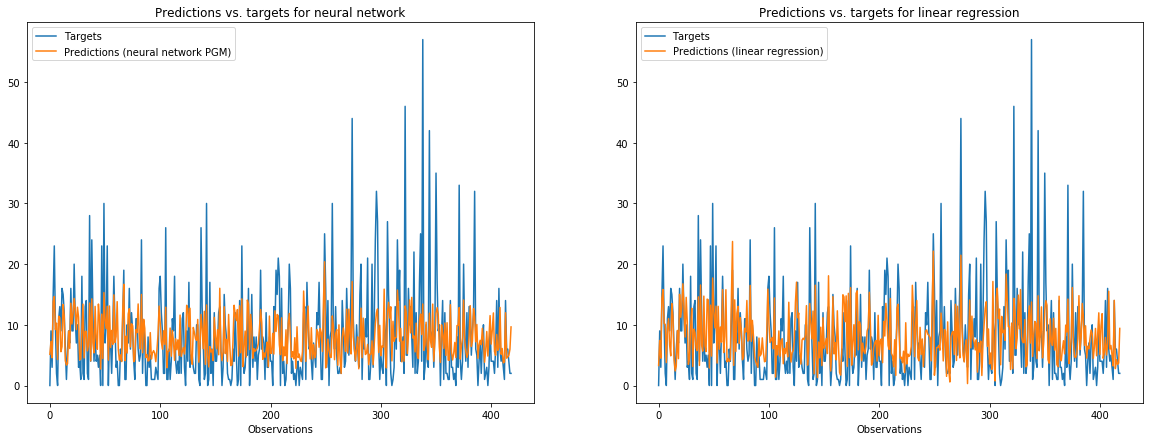

In [10]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].plot(y_test, label="Targets")
ax[0].plot(y_hat, label="Predictions (neural network PGM)")
ax[0].legend()
ax[0].set_xlabel("Observations")
ax[0].set_title("Predictions vs. targets for neural network")

ax[1].plot(y_test, label="Targets")
ax[1].plot(y_hat_lreg, label="Predictions (linear regression)")
ax[1].legend()
ax[1].set_xlabel("Observations")
ax[1].set_title("Predictions vs. targets for linear regression")
plt.show()

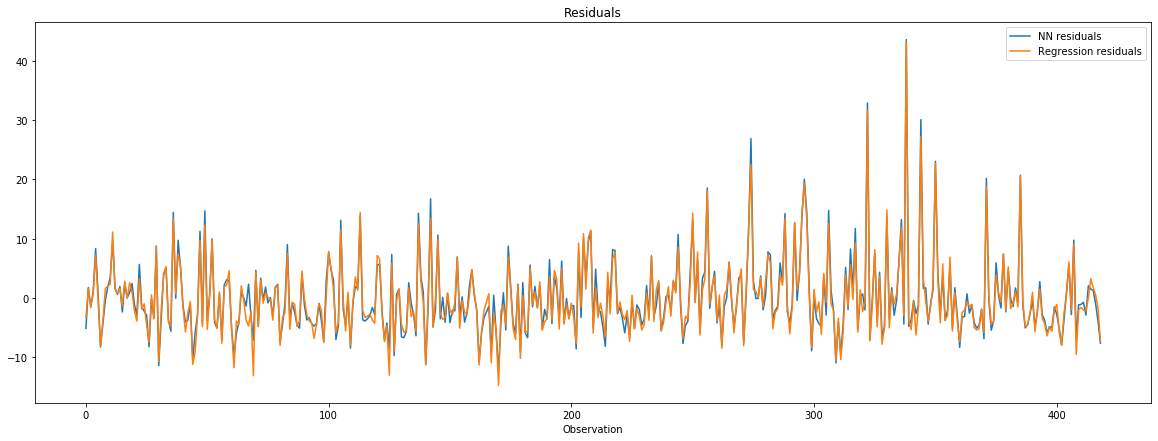

In [11]:
fig, ax = plt.subplots(1,1, figsize=(20,7))

ax.plot(y_test-y_hat, label="NN residuals")
ax.plot(y_test-y_hat_lreg, label="Regression residuals")
ax.legend()
ax.set_xlabel("Observation")
plt.title("Residuals")
plt.show()